In [59]:
# MSS used from screen capture
from mss import mss
# Sending commands to game.
import pydirectinput

# Googles OCR package used to know when the game ends.
import pytesseract
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"

# OpenCV allows us to do frame processing
import cv2

import numpy as np
from matplotlib import pyplot as plt
import time

# Environment components
from gym import Env
from gym.spaces import Box, Discrete

In [60]:
class WebGame(Env):
    
    def __init__(self):
        super().__init__()
        self.final_width, self.final_height = 80, 60
        self.observation_space = Box(low=0, high=255, shape=(1,self.final_height,self.final_width), dtype=np.uint8)
        self.action_space = Discrete(3)

        # # Only Monitor 2
        # with mss() as sct:
        #     self.mon0 = sct.monitors[0]
        #     self.mon2 = sct.monitors[2]
        #     print("Net Display:", self.mon0)
        #     print("Display 1:  ", self.mon1)

        # Both Monitor
        with mss() as sct:
            self.mon0 = sct.monitors[0]
            self.mon1 = sct.monitors[1]
            self.mon2 = sct.monitors[2]
            print("Net Display:", self.mon0)
            print("Display 1:  ", self.mon1)
            print("Display 2:  ", self.mon2)

        # Extraction parameters for the game.
        self.cap = mss()
        self.game_location = {'top':self.mon2['top'] + 130, 'left':self.mon2['left'] + 100, 'width':400, 'height':300}
        self.done_location = {'top':self.mon2['top'] + 293, 'left':self.mon2['left'] + 650, 'width':67, 'height':50}

    def step(self, action):
        # 0 = Jump, 1 = Duck, 2 = No Action
        action_map = {0: 'space', 1: 'down', 2: 'no_op'}
        if action != 2:
            pydirectinput.press(action_map[action])
        done, _ = self.get_done()
        new_observation = self.get_observation()
        reward = 1
        info = {}
        return new_observation, reward, done, info

    def reset(self):
        # Sleep added to make sure that the code has enough time for logging and saving models in b/w games.
        time.sleep(0.01)
        pydirectinput.click(x=self.mon2['left'] + 100, y=self.mon2['top'] + 100)
        pydirectinput.press('space')
        return self.get_observation()

    ### Unused
    def render(self):
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) and 0xFF == ord('q'):
            self.close()

    ### Unused
    def close(self):
        cv2.destroyAllWindows()
        
    def get_observation(self):        
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3].astype(np.uint8)
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (self.final_width, self.final_height))
        channel = np.reshape(resized, (1, self.final_height, self.final_width))
        return channel

        
    def get_done(self):
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        reset_vector = done_cap[:,:,1]
        # Done is True if the middle portion of screen has a Repeat Symbol.
        # Better than using any OCR to read static score or "GAME OVER" text in middle of screen.
        # With OCR: 2-4 fps
        # With reading the reset_vector: 10-20 fps 
        # We read the status of corner pixels to make sure that this is the reset symbol and not a dragon.
        done = (reset_vector[0,0] == reset_vector[49,0] == reset_vector[0,66] == reset_vector[49,66] == 172)
        return done, done_cap

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


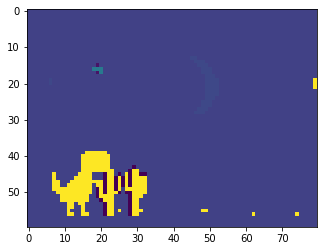

In [61]:
env = WebGame()
obs = env.get_observation()
plt.imshow(obs[0])

True


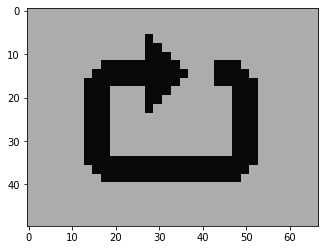

In [62]:
status = env.get_done()
print(status[0])
plt.imshow(status[-1])

In [63]:
import os 

from stable_baselines3.common.callbacks import BaseCallback

from stable_baselines3 import DQN

best_model_version = 0

In [64]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, f'best_model_{self.n_calls+best_model_version}')
            self.model.save(model_path)
        return True

In [65]:
CHECKPOINT_DIR = './Saved_Models_Optimized'
LOG_DIR = './Logs_Optimized/'

In [66]:
callback = TrainAndLoggingCallback(check_freq=5000, save_path=CHECKPOINT_DIR)

In [67]:
env = WebGame()
model = None

Net Display: {'left': 0, 'top': 0, 'width': 3926, 'height': 1440}
Display 1:   {'left': 0, 'top': 0, 'width': 2560, 'height': 1440}
Display 2:   {'left': 2560, 'top': 339, 'width': 1366, 'height': 768}


In [68]:
def LatestModelLoad():
    global model, best_model_version
    path = "C:\\AnCodeRR\\Google_Dino_Game_AI\\Saved_Models\\"
    saves = os.listdir(path=path)
    if len(saves) == 0: 
        return
    len_to_shave = len("best_model_")
    best_model_version = max([int(s[len_to_shave:-4]) for s in saves])
    model = DQN.load(f"C:\\AnCodeRR\\Google_Dino_Game_AI\\Saved_Models\\best_model_{best_model_version}.zip", env=env, )
    print(f'{"#"*50}\nFound saved model version {best_model_version}.\nModel version {best_model_version} is now loaded\n{"#"*50}')

LatestModelLoad()
if not model:
    model = DQN(
        policy = 'CnnPolicy', 
        env = env, 
        tensorboard_log = LOG_DIR, 
        verbose = 1, 
        buffer_size = 10000, 
        learning_starts = 0)
    print(f'{"#"*50}\nNo saved model found. Creating new model from scratch\n{"#"*50}')

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
##################################################
Found saved model version 40000.
Model version 40000 is now loaded
##################################################


In [29]:
model.learn(total_timesteps=10000, callback=callback)

Logging to ./Logs/DQN_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 5.25     |
|    ep_rew_mean      | 5.25     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 12       |
|    total_timesteps  | 21       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.482    |
|    n_updates        | 5        |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 7.5      |
|    ep_rew_mean      | 7.5      |
|    exploration_rate | 0.986    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 2        |
|    time_elapsed     | 27       |
|    total_timesteps  | 60       |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.375  

In [34]:

def automated_player(episodes, use_dqn=False):
    i = 0
    total_frames_processed = 0
    total_time_for_processing = 0
    for episode in range(episodes):
        start_time = time.time()
        obs = env.reset()
        done = False
        total_reward = 0
        while not done:
            i += 1 
            if use_dqn:
                action, _ = model.predict(obs)
                obs, reward, done, _ = env.step(int(action))
            else:
                obs, reward , done, _ = env.step(env.action_space.sample())
            total_frames_processed += 1
            # plt.imsave(fname=f"C:\AnCodeRR\Google_Dino_Game_AI\{i}.png", arr=obs[0])
            total_reward += reward
        total_time_for_processing += time.time() - start_time
        print(f'Total Reward for epoch {episode} is {total_reward}')
    print(f"Total Frames Processed are {total_frames_processed} in {total_time_for_processing:.2f} seconds")


In [35]:
automated_player(5, False)

Total Reward for epoch 0 is 25


KeyboardInterrupt: 

In [186]:
automated_player(5, True)

Total Reward for epoch 0 is 115
Total Reward for epoch 1 is 157
Total Reward for epoch 2 is 168
Total Reward for epoch 3 is 91
Total Reward for epoch 4 is 288
Total Frames Processed are 819 in 48.68 seconds
